# Import dependencies

In [15]:
import datetime
import random
import os
import logging
import time
import tqdm
import itertools
import json

import cv2
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel
from fvcore.common.timer import Timer

import detectron2
from detectron2 import model_zoo
from detectron2.engine import (
    DefaultPredictor,
    DefaultTrainer,
    HookBase,
    SimpleTrainer,
    hooks,
)
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.data import (
    MetadataCatalog,
    DatasetCatalog,
    DatasetMapper,
    DatasetFromList,
    build_detection_train_loader,
    build_detection_test_loader,
)

from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger, log_every_n_seconds
from detectron2.evaluation import COCOEvaluator
from detectron2.modeling import build_model
from detectron2.solver import build_optimizer
from detectron2.utils import comm
from detectron2.utils.events import CommonMetricPrinter
from detectron2.utils.analysis import parameter_count_table

setup_logger()
logger = logging.getLogger("detectron2")

# For Reproducibility

In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(seed=1234)

# Limited the usage of GPU


In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

# Prepare dataset

In [6]:
# Register the coco instance
DATASET_NAME = "midv"
DATASET_SRC = "/data/card-segmentation/midv/"

for d in ["train", "val", "test"]:
    register_coco_instances(
        f"{DATASET_NAME}_{d}",
        {},
        f"{DATASET_SRC}{DATASET_NAME}_{d}.json",
        f"{DATASET_SRC}",
    )

# Create metadata for train ,and val dataset
train_metadata = MetadataCatalog.get(f"{DATASET_NAME}_train")
train_dataset_dicts = DatasetCatalog.get(f"{DATASET_NAME}_train")

val_metadata = MetadataCatalog.get(f"{DATASET_NAME}_val")
val_dataset_dicts = DatasetCatalog.get(f"{DATASET_NAME}_val")

[07/26 09:55:12 d2.data.datasets.coco]: Loaded 15087 images in COCO format from /data/card-segmentation/midv/midv_train.json
[07/26 09:55:12 d2.data.datasets.coco]: Loaded 690 images in COCO format from /data/card-segmentation/midv/midv_val.json


# Visualize the dataset

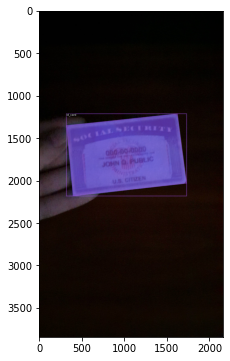

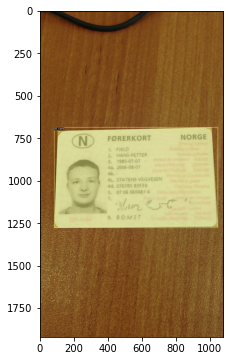

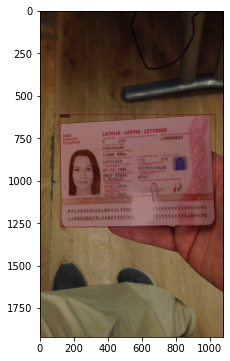

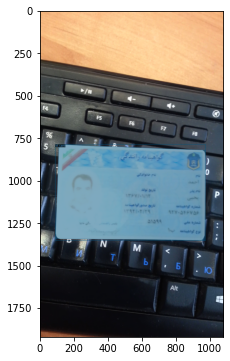

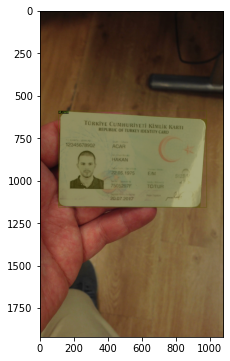

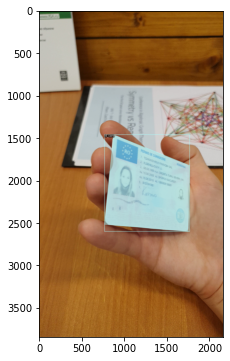

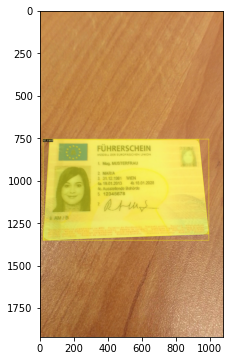

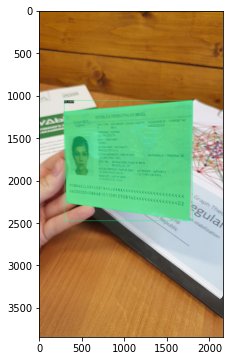

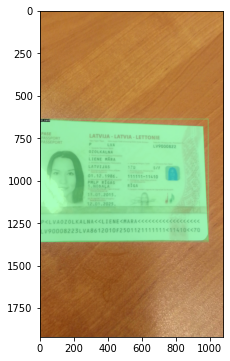

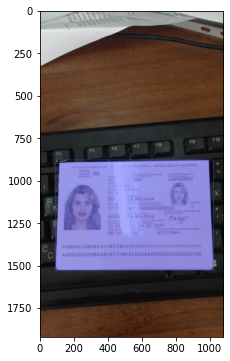

In [7]:
def visualize(dataset, metadata, size):
    for d in random.sample(dataset, size):
        img = cv2.imread(d["file_name"])
        v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1)
        v = v.draw_dataset_dict(d)
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
        plt.show()


visualize(train_dataset_dicts, train_metadata, 5)
visualize(val_dataset_dicts, val_metadata, 5)

# Model training

## Define customize trainer for monitoning validation loss

In [8]:
class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (
                    time.perf_counter() - start_time
                ) / iters_after_start
                eta = datetime.timedelta(
                    seconds=int(total_seconds_per_img * (total - idx - 1))
                )
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar("validation_loss", mean_loss)
        comm.synchronize()

        return losses

    def _get_loss(self, data):
        # How loss is calculated on train_loop
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced

    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)


class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(
            -1,
            LossEvalHook(
                self.cfg.TEST.EVAL_PERIOD,
                self.model,
                build_detection_test_loader(
                    self.cfg, self.cfg.DATASETS.TEST[0], DatasetMapper(self.cfg, True)
                ),
            ),
        )
        return hooks

## Function for training with different models

In [9]:
def create_config(model_yaml: str, output_dir: str, num_classes: int):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_yaml))

    cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_train",)
    cfg.DATASETS.TEST = (f"{DATASET_NAME}_val",)
    cfg.TEST.EVAL_PERIOD = 500
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_yaml)
    cfg.OUTPUT_DIR = output_dir
    cfg.SOLVER.IMS_PER_BATCH = 1
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 1500
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    return cfg


def start_training(config):
    os.makedirs(config.OUTPUT_DIR, exist_ok=True)
    trainer = CustomTrainer(config)
    trainer.resume_or_load(resume=False)
    trainer.train()

## Models for benchmark

In [10]:
experiment_dir = "/data/card-segmentation/models"

models = {
    "R50C4_COCO": "COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml",
    "R50FPN_COCO": "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
    "R50DV5_COCO": "COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml",
}

models_config = {}
for model, yaml in models.items():
    config = create_config(
        model_yaml=yaml, output_dir=os.path.join(experiment_dir, model), num_classes=1
    )
    models_config[model] = config
    start_training(config)

WARNING [07/26 09:55:26 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.
[07/26 09:55:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (

[07/26 09:55:32 d2.data.datasets.coco]: Loaded 15087 images in COCO format from /data/card-segmentation/midv/midv_train.json
[07/26 09:55:32 d2.data.build]: Removed 0 images with no usable annotations. 15087 images left.
[07/26 09:55:33 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  id_card   | 15087        |
|            |              |
[07/26 09:55:33 d2.data.common]: Serializing 15087 elements to byte tensors and concatenating them all ...
[07/26 09:55:33 d2.data.common]: Serialized dataset takes 4.44 MiB
[07/26 09:55:33 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/26 09:55:33 d2.data.build]: Using training sampler TrainingSampler
[07/26 09:55:33 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768,

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (2, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[07/26 09:55:33 d2.engine.train_loop]: Starting training from iteration 0
[07/26 09:55:45 d2.utils.events]:  eta: 0:14:05  iter: 19  total_loss: 1.698  loss_cls: 0.622  loss_box_reg: 0.166  loss_mask: 0.698  loss_rpn_cls: 0.119  loss_rpn_loc: 0.111  time: 0.5685  data_time: 0.0144  lr: 0.000005  max_mem: 2686M
[07/26 09:55:56 d2.utils.events]:  eta: 0:13:35  iter: 39  total_loss: 1.641  loss_cls: 0.509  loss_box_reg: 0.163  loss_mask: 0.681  loss_rpn_cls: 0.142  loss_rpn_loc: 0.096  time: 0.5605  data_time: 0.0027  lr: 0.000010  max_mem: 2686M
[07/26 09:56:07 d2.utils.events]:  eta: 0:13:25  iter: 59  total_loss: 1.379  loss_cls: 0.357  loss_box_reg: 0.148  loss_mask: 0.638  loss_rpn_cls: 0.108  loss_rpn_loc: 0.130  time: 0.5620  data_time: 0.0027  lr: 0.000015  max_mem: 2686M
[07/26 09:56:18 d2.utils.events]:  eta: 0:13:13  iter: 79  total_loss: 1.209  loss_cls: 0.260  loss_box_reg: 0.160  loss_mask: 0.571  loss_rpn_cls: 0.117  loss_rpn_loc: 0.087  time: 0.5602  data_time: 0.0024  lr:

[07/26 10:01:35 d2.evaluation.evaluator]: Inference done 480/690. 0.1461 s / img. ETA=0:00:36
[07/26 10:01:40 d2.evaluation.evaluator]: Inference done 505/690. 0.1463 s / img. ETA=0:00:32
[07/26 10:01:45 d2.evaluation.evaluator]: Inference done 526/690. 0.1468 s / img. ETA=0:00:29
[07/26 10:01:50 d2.evaluation.evaluator]: Inference done 546/690. 0.1471 s / img. ETA=0:00:26
[07/26 10:01:55 d2.evaluation.evaluator]: Inference done 567/690. 0.1472 s / img. ETA=0:00:22
[07/26 10:02:00 d2.evaluation.evaluator]: Inference done 589/690. 0.1473 s / img. ETA=0:00:18
[07/26 10:02:06 d2.evaluation.evaluator]: Inference done 611/690. 0.1474 s / img. ETA=0:00:14
[07/26 10:02:11 d2.evaluation.evaluator]: Inference done 632/690. 0.1478 s / img. ETA=0:00:10
[07/26 10:02:16 d2.evaluation.evaluator]: Inference done 653/690. 0.1480 s / img. ETA=0:00:07
[07/26 10:02:21 d2.evaluation.evaluator]: Inference done 674/690. 0.1480 s / img. ETA=0:00:03
[07/26 10:02:25 d2.evaluation.evaluator]: Total inference ti

[07/26 10:04:51 d2.utils.events]:  eta: 0:09:03  iter: 519  total_loss: 0.231  loss_cls: 0.030  loss_box_reg: 0.090  loss_mask: 0.043  loss_rpn_cls: 0.011  loss_rpn_loc: 0.052  validation_loss: 0.270  time: 0.5546  data_time: 0.0026  lr: 0.000130  max_mem: 2686M
[07/26 10:05:02 d2.utils.events]:  eta: 0:08:52  iter: 539  total_loss: 0.228  loss_cls: 0.025  loss_box_reg: 0.075  loss_mask: 0.040  loss_rpn_cls: 0.014  loss_rpn_loc: 0.063  validation_loss: 0.270  time: 0.5545  data_time: 0.0026  lr: 0.000135  max_mem: 2686M
[07/26 10:05:13 d2.utils.events]:  eta: 0:08:41  iter: 559  total_loss: 0.227  loss_cls: 0.026  loss_box_reg: 0.077  loss_mask: 0.039  loss_rpn_cls: 0.013  loss_rpn_loc: 0.048  validation_loss: 0.270  time: 0.5544  data_time: 0.0025  lr: 0.000140  max_mem: 2686M
[07/26 10:05:24 d2.utils.events]:  eta: 0:08:29  iter: 579  total_loss: 0.203  loss_cls: 0.026  loss_box_reg: 0.074  loss_mask: 0.039  loss_rpn_cls: 0.009  loss_rpn_loc: 0.045  validation_loss: 0.270  time: 0.55

[07/26 10:10:13 d2.evaluation.evaluator]: Inference done 363/690. 0.1483 s / img. ETA=0:00:51
[07/26 10:10:18 d2.evaluation.evaluator]: Inference done 396/690. 0.1478 s / img. ETA=0:00:46
[07/26 10:10:23 d2.evaluation.evaluator]: Inference done 428/690. 0.1478 s / img. ETA=0:00:41
[07/26 10:10:28 d2.evaluation.evaluator]: Inference done 460/690. 0.1480 s / img. ETA=0:00:36
[07/26 10:10:33 d2.evaluation.evaluator]: Inference done 492/690. 0.1480 s / img. ETA=0:00:31
[07/26 10:10:39 d2.evaluation.evaluator]: Inference done 517/690. 0.1483 s / img. ETA=0:00:27
[07/26 10:10:44 d2.evaluation.evaluator]: Inference done 542/690. 0.1488 s / img. ETA=0:00:24
[07/26 10:10:49 d2.evaluation.evaluator]: Inference done 567/690. 0.1491 s / img. ETA=0:00:20
[07/26 10:10:54 d2.evaluation.evaluator]: Inference done 592/690. 0.1491 s / img. ETA=0:00:16
[07/26 10:10:59 d2.evaluation.evaluator]: Inference done 617/690. 0.1492 s / img. ETA=0:00:12
[07/26 10:11:04 d2.evaluation.evaluator]: Inference done 642

[07/26 10:13:28 d2.utils.events]:  eta: 0:04:36  iter: 999  total_loss: 0.153  loss_cls: 0.022  loss_box_reg: 0.043  loss_mask: 0.033  loss_rpn_cls: 0.005  loss_rpn_loc: 0.044  validation_loss: 0.219  time: 0.5523  data_time: 0.0025  lr: 0.000250  max_mem: 2686M
[07/26 10:13:39 d2.utils.events]:  eta: 0:04:25  iter: 1019  total_loss: 0.153  loss_cls: 0.020  loss_box_reg: 0.034  loss_mask: 0.031  loss_rpn_cls: 0.007  loss_rpn_loc: 0.042  validation_loss: 0.219  time: 0.5521  data_time: 0.0026  lr: 0.000250  max_mem: 2686M
[07/26 10:13:50 d2.utils.events]:  eta: 0:04:14  iter: 1039  total_loss: 0.148  loss_cls: 0.016  loss_box_reg: 0.033  loss_mask: 0.033  loss_rpn_cls: 0.010  loss_rpn_loc: 0.040  validation_loss: 0.219  time: 0.5522  data_time: 0.0026  lr: 0.000250  max_mem: 2686M
[07/26 10:14:01 d2.utils.events]:  eta: 0:04:02  iter: 1059  total_loss: 0.136  loss_cls: 0.021  loss_box_reg: 0.036  loss_mask: 0.029  loss_rpn_cls: 0.007  loss_rpn_loc: 0.044  validation_loss: 0.219  time: 0

[07/26 10:18:47 d2.evaluation.evaluator]: Inference done 239/690. 0.1670 s / img. ETA=0:01:20
[07/26 10:18:52 d2.evaluation.evaluator]: Inference done 267/690. 0.1669 s / img. ETA=0:01:15
[07/26 10:18:57 d2.evaluation.evaluator]: Inference done 295/690. 0.1671 s / img. ETA=0:01:10
[07/26 10:19:02 d2.evaluation.evaluator]: Inference done 322/690. 0.1678 s / img. ETA=0:01:06
[07/26 10:19:07 d2.evaluation.evaluator]: Inference done 352/690. 0.1671 s / img. ETA=0:01:00
[07/26 10:19:12 d2.evaluation.evaluator]: Inference done 380/690. 0.1673 s / img. ETA=0:00:55
[07/26 10:19:17 d2.evaluation.evaluator]: Inference done 408/690. 0.1674 s / img. ETA=0:00:50
[07/26 10:19:22 d2.evaluation.evaluator]: Inference done 437/690. 0.1673 s / img. ETA=0:00:45
[07/26 10:19:27 d2.evaluation.evaluator]: Inference done 465/690. 0.1673 s / img. ETA=0:00:40
[07/26 10:19:32 d2.evaluation.evaluator]: Inference done 493/690. 0.1674 s / img. ETA=0:00:35
[07/26 10:19:38 d2.evaluation.evaluator]: Inference done 517

[07/26 10:22:00 detectron2]: Loss on Validation  done 547/690. 0.0000 s / img. ETA=0:00:27
[07/26 10:22:05 detectron2]: Loss on Validation  done 572/690. 0.0000 s / img. ETA=0:00:22
[07/26 10:22:10 detectron2]: Loss on Validation  done 596/690. 0.0000 s / img. ETA=0:00:17
[07/26 10:22:15 detectron2]: Loss on Validation  done 619/690. 0.0000 s / img. ETA=0:00:13
[07/26 10:22:20 detectron2]: Loss on Validation  done 642/690. 0.0000 s / img. ETA=0:00:09
[07/26 10:22:25 detectron2]: Loss on Validation  done 667/690. 0.0000 s / img. ETA=0:00:04
[07/26 10:22:30 d2.utils.events]:  eta: 0:00:00  iter: 1499  total_loss: 0.138  loss_cls: 0.019  loss_box_reg: 0.034  loss_mask: 0.026  loss_rpn_cls: 0.009  loss_rpn_loc: 0.044  validation_loss: 0.168  time: 0.5514  data_time: 0.0026  lr: 0.000250  max_mem: 2686M
[07/26 10:22:30 d2.engine.hooks]: Overall training speed: 1497 iterations in 0:13:45 (0.5517 s / it)
[07/26 10:22:30 d2.engine.hooks]: Total training time: 0:26:55 (0:13:09 on hooks)
[07/26 

[07/26 10:22:31 d2.data.datasets.coco]: Loaded 15087 images in COCO format from /data/card-segmentation/midv/midv_train.json
[07/26 10:22:31 d2.data.build]: Removed 0 images with no usable annotations. 15087 images left.
[07/26 10:22:32 d2.data.common]: Serializing 15087 elements to byte tensors and concatenating them all ...
[07/26 10:22:32 d2.data.common]: Serialized dataset takes 4.44 MiB
[07/26 10:22:32 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/26 10:22:32 d2.data.build]: Using training sampler TrainingSampler
[07/26 10:22:32 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/26 10:22:32 d2.data.datasets.coco]: Loaded 690 images in COCO format from /data/card-segmentation/midv/midv_val.json
[07/26 10:22:32 d2.da

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[07/26 10:22:32 d2.engine.train_loop]: Starting training from iteration 0
[07/26 10:22:38 d2.utils.events]:  eta: 0:07:25  iter: 19  total_loss: 1.711  loss_cls: 0.886  loss_box_reg: 0.139  loss_mask: 0.686  loss_rpn_cls: 0.003  loss_rpn_loc: 0.007  time: 0.3000  data_time: 0.0311  lr: 0.000005  max_mem: 2686M
[07/26 10:22:44 d2.utils.events]:  eta: 0:07:17  iter: 39  total_loss: 1.559  loss_cls: 0.719  loss_box_reg: 0.157  loss_mask: 0.651  loss_rpn_cls: 0.004  loss_rpn_loc: 0.007  time: 0.2974  data_time: 0.0034  lr: 0.000010  max_mem: 2686M
[07/26 10:22:50 d2.utils.events]:  eta: 0:07:11  iter: 59  total_loss: 1.267  loss_cls: 0.525  loss_box_reg: 0.121  loss_mask: 0.602  loss_rpn_cls: 0.005  loss_rpn_loc: 0.009  time: 0.2973  data_time: 0.0060  lr: 0.000015  max_mem: 2686M
[07/26 10:22:56 d2.utils.events]:  eta: 0:07:04  iter: 79  total_loss: 1.049  loss_cls: 0.357  loss_box_reg: 0.143  loss_mask: 0.523  loss_rpn_cls: 0.005  loss_rpn_loc: 0.010  time: 0.2954  data_time: 0.0022  lr:

[07/26 10:26:23 d2.evaluation.evaluator]: Inference done 597/690. 0.0997 s / img. ETA=0:00:12
[07/26 10:26:28 d2.evaluation.evaluator]: Inference done 621/690. 0.0999 s / img. ETA=0:00:09
[07/26 10:26:33 d2.evaluation.evaluator]: Inference done 646/690. 0.1001 s / img. ETA=0:00:06
[07/26 10:26:38 d2.evaluation.evaluator]: Inference done 671/690. 0.1002 s / img. ETA=0:00:02
[07/26 10:26:42 d2.evaluation.evaluator]: Total inference time: 0:01:41.137948 (0.147647 s / img per device, on 1 devices)
[07/26 10:26:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:01:08 (0.100280 s / img per device, on 1 devices)
[07/26 10:26:42 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/26 10:26:42 d2.evaluation.coco_evaluation]: Saving results to /data/card-segmentation/models/R50FPN_COCO/inference/coco_instances_results.json
[07/26 10:26:42 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index..

[07/26 10:28:56 d2.utils.events]:  eta: 0:04:21  iter: 619  total_loss: 0.118  loss_cls: 0.029  loss_box_reg: 0.046  loss_mask: 0.039  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  validation_loss: 0.182  time: 0.2956  data_time: 0.0024  lr: 0.000155  max_mem: 2686M
[07/26 10:29:02 d2.utils.events]:  eta: 0:04:15  iter: 639  total_loss: 0.117  loss_cls: 0.026  loss_box_reg: 0.046  loss_mask: 0.039  loss_rpn_cls: 0.000  loss_rpn_loc: 0.004  validation_loss: 0.182  time: 0.2960  data_time: 0.0036  lr: 0.000160  max_mem: 2686M
[07/26 10:29:08 d2.utils.events]:  eta: 0:04:10  iter: 659  total_loss: 0.119  loss_cls: 0.027  loss_box_reg: 0.051  loss_mask: 0.034  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.182  time: 0.2960  data_time: 0.0047  lr: 0.000165  max_mem: 2686M
[07/26 10:29:14 d2.utils.events]:  eta: 0:04:04  iter: 679  total_loss: 0.106  loss_cls: 0.025  loss_box_reg: 0.037  loss_mask: 0.038  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.182  time: 0.29

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.18 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.00 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.914
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.914
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.945
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.945
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.

[07/26 10:34:58 d2.utils.events]:  eta: 0:01:29  iter: 1199  total_loss: 0.068  loss_cls: 0.016  loss_box_reg: 0.019  loss_mask: 0.028  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.134  time: 0.2962  data_time: 0.0023  lr: 0.000250  max_mem: 2686M
[07/26 10:35:04 d2.utils.events]:  eta: 0:01:23  iter: 1219  total_loss: 0.065  loss_cls: 0.015  loss_box_reg: 0.020  loss_mask: 0.030  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.134  time: 0.2962  data_time: 0.0049  lr: 0.000250  max_mem: 2686M
[07/26 10:35:10 d2.utils.events]:  eta: 0:01:18  iter: 1239  total_loss: 0.067  loss_cls: 0.016  loss_box_reg: 0.021  loss_mask: 0.024  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.134  time: 0.2962  data_time: 0.0024  lr: 0.000250  max_mem: 2686M
[07/26 10:35:16 d2.utils.events]:  eta: 0:01:12  iter: 1259  total_loss: 0.061  loss_cls: 0.014  loss_box_reg: 0.016  loss_mask: 0.025  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  validation_loss: 0.134  time: 

[07/26 10:38:01 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
COCOeval_opt.evaluate() finished in 0.26 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.00 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.983
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.983
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.990
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all

[07/26 10:39:39 d2.data.datasets.coco]: Loaded 15087 images in COCO format from /data/card-segmentation/midv/midv_train.json
[07/26 10:39:40 d2.data.build]: Removed 0 images with no usable annotations. 15087 images left.
[07/26 10:39:40 d2.data.common]: Serializing 15087 elements to byte tensors and concatenating them all ...
[07/26 10:39:40 d2.data.common]: Serialized dataset takes 4.44 MiB
[07/26 10:39:40 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/26 10:39:40 d2.data.build]: Using training sampler TrainingSampler
[07/26 10:39:40 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/26 10:39:40 d2.data.datasets.coco]: Loaded 690 images in COCO format from /data/card-segmentation/midv/midv_val.json
[07/26 10:39:40 d2.da

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[07/26 10:39:41 d2.engine.train_loop]: Starting training from iteration 0
[07/26 10:39:51 d2.utils.events]:  eta: 0:12:12  iter: 19  total_loss: 1.682  loss_cls: 0.625  loss_box_reg: 0.163  loss_mask: 0.686  loss_rpn_cls: 0.068  loss_rpn_loc: 0.123  time: 0.5018  data_time: 0.0318  lr: 0.000005  max_mem: 3375M
[07/26 10:40:01 d2.utils.events]:  eta: 0:12:00  iter: 39  total_loss: 1.516  loss_cls: 0.505  loss_box_reg: 0.183  loss_mask: 0.643  loss_rpn_cls: 0.049  loss_rpn_loc: 0.099  time: 0.4964  data_time: 0.0023  lr: 0.000010  max_mem: 3375M
[07/26 10:40:11 d2.utils.events]:  eta: 0:11:50  iter: 59  total_loss: 1.271  loss_cls: 0.387  loss_box_reg: 0.170  loss_mask: 0.577  loss_rpn_cls: 0.065  loss_rpn_loc: 0.052  time: 0.4967  data_time: 0.0023  lr: 0.000015  max_mem: 3375M
[07/26 10:40:21 d2.utils.events]:  eta: 0:11:40  iter: 79  total_loss: 1.080  loss_cls: 0.256  loss_box_reg: 0.164  loss_mask: 0.478  loss_rpn_cls: 0.060  loss_rpn_loc: 0.093  time: 0.4983  data_time: 0.0023  lr:

[07/26 10:45:20 d2.evaluation.evaluator]: Inference done 500/690. 0.1386 s / img. ETA=0:00:31
[07/26 10:45:25 d2.evaluation.evaluator]: Inference done 518/690. 0.1389 s / img. ETA=0:00:29
[07/26 10:45:30 d2.evaluation.evaluator]: Inference done 536/690. 0.1392 s / img. ETA=0:00:26
[07/26 10:45:35 d2.evaluation.evaluator]: Inference done 556/690. 0.1395 s / img. ETA=0:00:23
[07/26 10:45:40 d2.evaluation.evaluator]: Inference done 575/690. 0.1397 s / img. ETA=0:00:20
[07/26 10:45:45 d2.evaluation.evaluator]: Inference done 595/690. 0.1398 s / img. ETA=0:00:17
[07/26 10:45:50 d2.evaluation.evaluator]: Inference done 613/690. 0.1401 s / img. ETA=0:00:14
[07/26 10:45:55 d2.evaluation.evaluator]: Inference done 632/690. 0.1403 s / img. ETA=0:00:10
[07/26 10:46:00 d2.evaluation.evaluator]: Inference done 651/690. 0.1404 s / img. ETA=0:00:07
[07/26 10:46:06 d2.evaluation.evaluator]: Inference done 670/690. 0.1406 s / img. ETA=0:00:03
[07/26 10:46:11 d2.evaluation.evaluator]: Inference done 690

[07/26 10:48:26 d2.utils.events]:  eta: 0:08:06  iter: 539  total_loss: 0.158  loss_cls: 0.022  loss_box_reg: 0.054  loss_mask: 0.032  loss_rpn_cls: 0.009  loss_rpn_loc: 0.033  validation_loss: 0.208  time: 0.5085  data_time: 0.0026  lr: 0.000135  max_mem: 3693M
[07/26 10:48:37 d2.utils.events]:  eta: 0:07:56  iter: 559  total_loss: 0.155  loss_cls: 0.023  loss_box_reg: 0.054  loss_mask: 0.027  loss_rpn_cls: 0.004  loss_rpn_loc: 0.037  validation_loss: 0.208  time: 0.5090  data_time: 0.0025  lr: 0.000140  max_mem: 3693M
[07/26 10:48:47 d2.utils.events]:  eta: 0:07:46  iter: 579  total_loss: 0.155  loss_cls: 0.020  loss_box_reg: 0.051  loss_mask: 0.034  loss_rpn_cls: 0.002  loss_rpn_loc: 0.042  validation_loss: 0.208  time: 0.5090  data_time: 0.0023  lr: 0.000145  max_mem: 3693M
[07/26 10:48:57 d2.utils.events]:  eta: 0:07:36  iter: 599  total_loss: 0.146  loss_cls: 0.025  loss_box_reg: 0.041  loss_mask: 0.031  loss_rpn_cls: 0.007  loss_rpn_loc: 0.032  validation_loss: 0.208  time: 0.50

[07/26 10:53:31 d2.evaluation.evaluator]: Inference done 445/690. 0.1540 s / img. ETA=0:00:40
[07/26 10:53:36 d2.evaluation.evaluator]: Inference done 476/690. 0.1540 s / img. ETA=0:00:34
[07/26 10:53:41 d2.evaluation.evaluator]: Inference done 504/690. 0.1541 s / img. ETA=0:00:30
[07/26 10:53:47 d2.evaluation.evaluator]: Inference done 529/690. 0.1542 s / img. ETA=0:00:26
[07/26 10:53:52 d2.evaluation.evaluator]: Inference done 553/690. 0.1544 s / img. ETA=0:00:23
[07/26 10:53:57 d2.evaluation.evaluator]: Inference done 578/690. 0.1546 s / img. ETA=0:00:19
[07/26 10:54:02 d2.evaluation.evaluator]: Inference done 602/690. 0.1546 s / img. ETA=0:00:15
[07/26 10:54:07 d2.evaluation.evaluator]: Inference done 626/690. 0.1547 s / img. ETA=0:00:11
[07/26 10:54:12 d2.evaluation.evaluator]: Inference done 650/690. 0.1548 s / img. ETA=0:00:06
[07/26 10:54:17 d2.evaluation.evaluator]: Inference done 674/690. 0.1549 s / img. ETA=0:00:02
[07/26 10:54:21 d2.evaluation.evaluator]: Total inference ti

[07/26 10:56:35 d2.utils.events]:  eta: 0:03:53  iter: 1039  total_loss: 0.110  loss_cls: 0.016  loss_box_reg: 0.033  loss_mask: 0.025  loss_rpn_cls: 0.001  loss_rpn_loc: 0.026  validation_loss: 0.166  time: 0.5053  data_time: 0.0026  lr: 0.000250  max_mem: 3693M
[07/26 10:56:46 d2.utils.events]:  eta: 0:03:43  iter: 1059  total_loss: 0.109  loss_cls: 0.017  loss_box_reg: 0.029  loss_mask: 0.028  loss_rpn_cls: 0.003  loss_rpn_loc: 0.027  validation_loss: 0.166  time: 0.5055  data_time: 0.0026  lr: 0.000250  max_mem: 3693M
[07/26 10:56:56 d2.utils.events]:  eta: 0:03:33  iter: 1079  total_loss: 0.106  loss_cls: 0.014  loss_box_reg: 0.024  loss_mask: 0.021  loss_rpn_cls: 0.001  loss_rpn_loc: 0.026  validation_loss: 0.166  time: 0.5054  data_time: 0.0025  lr: 0.000250  max_mem: 3693M
[07/26 10:57:06 d2.utils.events]:  eta: 0:03:22  iter: 1099  total_loss: 0.092  loss_cls: 0.016  loss_box_reg: 0.024  loss_mask: 0.024  loss_rpn_cls: 0.001  loss_rpn_loc: 0.020  validation_loss: 0.166  time: 

[07/26 11:01:41 d2.evaluation.evaluator]: Inference done 445/690. 0.1546 s / img. ETA=0:00:40
[07/26 11:01:46 d2.evaluation.evaluator]: Inference done 476/690. 0.1545 s / img. ETA=0:00:35
[07/26 11:01:51 d2.evaluation.evaluator]: Inference done 503/690. 0.1546 s / img. ETA=0:00:30
[07/26 11:01:56 d2.evaluation.evaluator]: Inference done 527/690. 0.1547 s / img. ETA=0:00:27
[07/26 11:02:01 d2.evaluation.evaluator]: Inference done 552/690. 0.1549 s / img. ETA=0:00:23
[07/26 11:02:06 d2.evaluation.evaluator]: Inference done 577/690. 0.1551 s / img. ETA=0:00:19
[07/26 11:02:12 d2.evaluation.evaluator]: Inference done 602/690. 0.1551 s / img. ETA=0:00:15
[07/26 11:02:17 d2.evaluation.evaluator]: Inference done 627/690. 0.1552 s / img. ETA=0:00:10
[07/26 11:02:22 d2.evaluation.evaluator]: Inference done 651/690. 0.1553 s / img. ETA=0:00:06
[07/26 11:02:27 d2.evaluation.evaluator]: Inference done 675/690. 0.1554 s / img. ETA=0:00:02
[07/26 11:02:30 d2.evaluation.evaluator]: Total inference ti

# Benchmark

| Name   | train time (s/iter) | inference time (s/im) | train memory (GB) | Segmentation AP |
|--------|---------------------|-----------------------|-------------------|-----------------|
| R50C4  |                     |                       |                   |                 |
| R50D5  |                     |                       |                   |                 |
| R50FPN |                     |                       |                   |                 |

In [16]:
def benchmark_training(model, cfg):
    if comm.get_world_size() > 1:
        model = DistributedDataParallel(
            model, device_ids=[comm.get_local_rank()], broadcast_buffers=False
        )
    optimizer = build_optimizer(cfg, model)
    checkpointer = DetectionCheckpointer(model, optimizer=optimizer)
    checkpointer.load(cfg.MODEL.WEIGHTS)

    data_loader = build_detection_train_loader(cfg)
    dummy_data = list(itertools.islice(data_loader, 100))

    def f():
        data = DatasetFromList(dummy_data, copy=False)
        while True:
            yield from data

    max_iter = 400
    trainer = SimpleTrainer(model, f(), optimizer)
    trainer.register_hooks(
        [hooks.IterationTimer(), hooks.PeriodicWriter([CommonMetricPrinter(max_iter)])]
    )
    trainer.train(1, max_iter)


def benchmark_inference(model, cfg):
    data_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
    dummy_data = list(itertools.islice(data_loader, 100))

    def f():
        while True:
            yield from DatasetFromList(dummy_data, copy=False)

    for _ in range(5):  # warmup
        model(dummy_data[0])

    max_iter = 400
    timer = Timer()
    with tqdm.tqdm(total=max_iter) as pbar:
        for idx, d in enumerate(f()):
            if idx == max_iter:
                break
            model(d)
            pbar.update()
    logger.info("{} iters in {} seconds.".format(max_iter, timer.seconds()))


def benchmark(model_name, cfg):
    print("Model: {}".format(model_name))

    # Default setting
    model = build_model(cfg)
    model.eval()
    DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

    cfg.defrost()
    cfg.DATALOADER.NUM_WORKERS = 0

    # Calculate model size
    logger.info("Parameter Count:\n" + parameter_count_table(model, max_depth=5))

    # Calculate inference speed
    benchmark_inference(model, cfg)

    # Benchmark training speed & memory usage
    benchmark_training(model, cfg)


for model, config in models_config.items():
    config.MODEL.WEIGHTS = os.path.join(experiment_dir, model, "model_final.pth")
    benchmark(model, config)

Model: R50C4_COCO
WARNING [07/26 11:26:03 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.
[07/26 11:26:03 d2.data.datasets.coco]: Loaded 690 images in COCO format from /data/card-segmentation/midv/midv_val.json
[07/26 11:26:03 d2.data.common]: Serializing 690 elements to byte tensors and concatenating them all ...
[07/26 11:26:03 d2.data.common]: Serialized dataset takes 0.20 MiB
[07/26 11:26:03 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]


  0%|          | 0/400 [00:00<?, ?it/s]

[07/26 11:26:14 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:26:14 d2.data.common]: Serialized dataset takes 286.08 MiB


 25%|██▌       | 100/400 [00:17<00:48,  6.18it/s]

[07/26 11:26:31 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:26:32 d2.data.common]: Serialized dataset takes 286.08 MiB


 50%|█████     | 200/400 [00:34<00:32,  6.14it/s]

[07/26 11:26:49 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:26:49 d2.data.common]: Serialized dataset takes 286.08 MiB


 75%|███████▌  | 300/400 [00:52<00:16,  6.16it/s]

[07/26 11:27:06 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:27:07 d2.data.common]: Serialized dataset takes 286.08 MiB


100%|██████████| 400/400 [01:09<00:00,  6.17it/s]

[07/26 11:27:24 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:27:24 d2.data.common]: Serialized dataset takes 286.08 MiB


100%|██████████| 400/400 [01:10<00:00,  5.69it/s]

[07/26 11:27:24 detectron2]: 400 iters in 70.33997090300545 seconds.
[07/26 11:27:24 detectron2]: Parameter Count:
| name                                                     | #elements or shape      |
|:---------------------------------------------------------|:------------------------|
| model                                                    | 35.1M                   |
|  backbone                                                |  8.5M                   |
|   backbone.stem                                          |   9.4K                  |
|    backbone.stem.conv1                                   |    9.4K                 |
|     backbone.stem.conv1.weight                           |     (64, 3, 7, 7)       |
|   backbone.res2                                          |   0.2M                  |
|    backbone.res2.0                                       |    73.7K                |
|     backbone.res2.0.shortcut                             |     16.4K               |
|      backbone

[07/26 11:27:25 d2.data.datasets.coco]: Loaded 15087 images in COCO format from /data/card-segmentation/midv/midv_train.json
[07/26 11:27:25 d2.data.build]: Removed 0 images with no usable annotations. 15087 images left.
[07/26 11:27:25 d2.data.common]: Serializing 15087 elements to byte tensors and concatenating them all ...
[07/26 11:27:25 d2.data.common]: Serialized dataset takes 4.44 MiB
[07/26 11:27:25 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/26 11:27:25 d2.data.build]: Using training sampler TrainingSampler
[07/26 11:27:46 d2.engine.train_loop]: Starting training from iteration 1
[07/26 11:27:46 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:27:46 d2.data.common]: Serialized dataset takes 256.30 MiB
[07/26 11:27:56 d2.utils.events]:  eta: 0:03:28  iter: 19  total_loss: 0.142  loss_cls: 0.

  0%|          | 0/400 [00:00<?, ?it/s]

[07/26 11:31:36 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:31:36 d2.data.common]: Serialized dataset takes 286.08 MiB


 25%|██▍       | 99/400 [00:10<00:29, 10.07it/s]

[07/26 11:31:46 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:31:47 d2.data.common]: Serialized dataset takes 286.08 MiB


 50%|████▉     | 199/400 [00:20<00:19, 10.07it/s]

[07/26 11:31:57 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:31:57 d2.data.common]: Serialized dataset takes 286.08 MiB


 75%|███████▍  | 299/400 [00:30<00:10, 10.09it/s]

[07/26 11:32:07 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:32:07 d2.data.common]: Serialized dataset takes 286.08 MiB


100%|██████████| 400/400 [00:41<00:00, 10.05it/s]

[07/26 11:32:17 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:32:18 d2.data.common]: Serialized dataset takes 286.08 MiB


100%|██████████| 400/400 [00:41<00:00,  9.63it/s]

[07/26 11:32:18 detectron2]: 400 iters in 41.558057663962245 seconds.
[07/26 11:32:18 detectron2]: Parameter Count:
| name                                                     | #elements or shape   |
|:---------------------------------------------------------|:---------------------|
| model                                                    | 43.9M                |
|  backbone                                                |  26.8M               |
|   backbone.fpn_lateral2                                  |   65.8K              |
|    backbone.fpn_lateral2.weight                          |    (256, 256, 1, 1)  |
|    backbone.fpn_lateral2.bias                            |    (256,)            |
|   backbone.fpn_output2                                   |   0.6M               |
|    backbone.fpn_output2.weight                           |    (256, 256, 3, 3)  |
|    backbone.fpn_output2.bias                             |    (256,)            |
|   backbone.fpn_lateral3                   

[07/26 11:32:18 d2.data.datasets.coco]: Loaded 15087 images in COCO format from /data/card-segmentation/midv/midv_train.json
[07/26 11:32:18 d2.data.build]: Removed 0 images with no usable annotations. 15087 images left.
[07/26 11:32:19 d2.data.common]: Serializing 15087 elements to byte tensors and concatenating them all ...
[07/26 11:32:19 d2.data.common]: Serialized dataset takes 4.44 MiB
[07/26 11:32:19 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/26 11:32:19 d2.data.build]: Using training sampler TrainingSampler
[07/26 11:32:39 d2.engine.train_loop]: Starting training from iteration 1
[07/26 11:32:39 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:32:40 d2.data.common]: Serialized dataset takes 255.35 MiB
[07/26 11:32:45 d2.utils.events]:  eta: 0:01:51  iter: 19  total_loss: 0.058  loss_cls: 0.

  0%|          | 0/400 [00:00<?, ?it/s]

[07/26 11:34:51 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:34:51 d2.data.common]: Serialized dataset takes 286.08 MiB


 25%|██▌       | 100/400 [00:16<00:46,  6.42it/s]

[07/26 11:35:07 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:35:08 d2.data.common]: Serialized dataset takes 286.08 MiB


 50%|█████     | 200/400 [00:32<00:31,  6.43it/s]

[07/26 11:35:23 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:35:24 d2.data.common]: Serialized dataset takes 286.08 MiB


 75%|███████▌  | 300/400 [00:48<00:15,  6.44it/s]

[07/26 11:35:40 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:35:40 d2.data.common]: Serialized dataset takes 286.08 MiB


100%|██████████| 400/400 [01:04<00:00,  6.44it/s]

[07/26 11:35:56 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:35:56 d2.data.common]: Serialized dataset takes 286.08 MiB


100%|██████████| 400/400 [01:04<00:00,  6.16it/s]

[07/26 11:35:56 detectron2]: 400 iters in 64.9701497220085 seconds.
[07/26 11:35:56 detectron2]: Parameter Count:
| name                                                     | #elements or shape      |
|:---------------------------------------------------------|:------------------------|
| model                                                    | 171.9M                  |
|  backbone                                                |  23.5M                  |
|   backbone.stem                                          |   9.4K                  |
|    backbone.stem.conv1                                   |    9.4K                 |
|     backbone.stem.conv1.weight                           |     (64, 3, 7, 7)       |
|   backbone.res2                                          |   0.2M                  |
|    backbone.res2.0                                       |    73.7K                |
|     backbone.res2.0.shortcut                             |     16.4K               |
|      backbone.

[07/26 11:35:57 d2.data.datasets.coco]: Loaded 15087 images in COCO format from /data/card-segmentation/midv/midv_train.json
[07/26 11:35:57 d2.data.build]: Removed 0 images with no usable annotations. 15087 images left.
[07/26 11:35:58 d2.data.common]: Serializing 15087 elements to byte tensors and concatenating them all ...
[07/26 11:35:58 d2.data.common]: Serialized dataset takes 4.44 MiB
[07/26 11:35:58 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/26 11:35:58 d2.data.build]: Using training sampler TrainingSampler
[07/26 11:36:14 d2.engine.train_loop]: Starting training from iteration 1
[07/26 11:36:14 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/26 11:36:15 d2.data.common]: Serialized dataset takes 259.49 MiB
[07/26 11:36:24 d2.utils.events]:  eta: 0:03:10  iter: 19  total_loss: 0.085  loss_cls: 0.

# Plot the loss for training and validation set

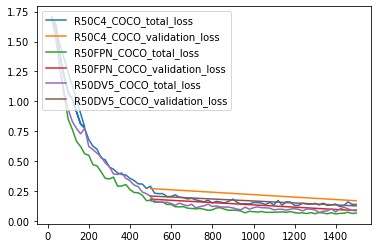

In [17]:
def load_json_arr(json_path):
    lines = []
    with open(json_path, "r") as f:
        for line in f:
            lines.append(json.loads(line))
    return lines


legends = []
for model, config in models_config.items():
    metrics = load_json_arr(os.path.join(config.OUTPUT_DIR, "metrics.json"))
    plt.plot([x["iteration"] for x in metrics], [x["total_loss"] for x in metrics])
    plt.plot(
        [x["iteration"] for x in metrics if "validation_loss" in x],
        [x["validation_loss"] for x in metrics if "validation_loss" in x],
    )
    legends.extend([f"{model}_total_loss", f"{model}_validation_loss"])
plt.legend(legends, loc="upper left")
plt.show()

# Visualize the prediction result

Prediction result from model: R50C4_COCO
WARNING [07/26 11:45:13 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.
[07/26 11:45:14 d2.data.datasets.coco]: Loaded 4802 images in COCO format from /data/card-segmentation/midv/midv_test.json


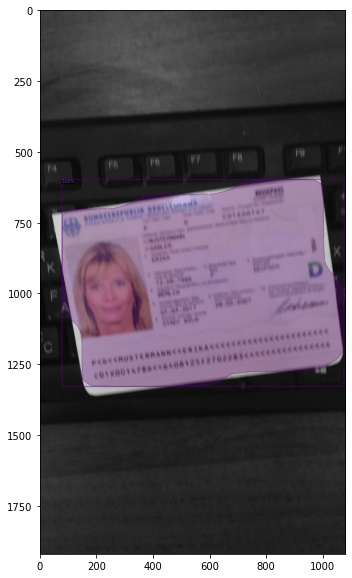

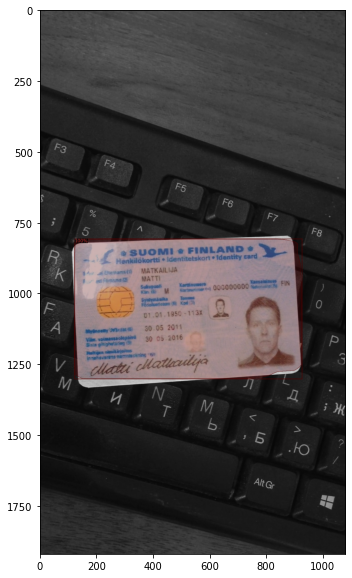

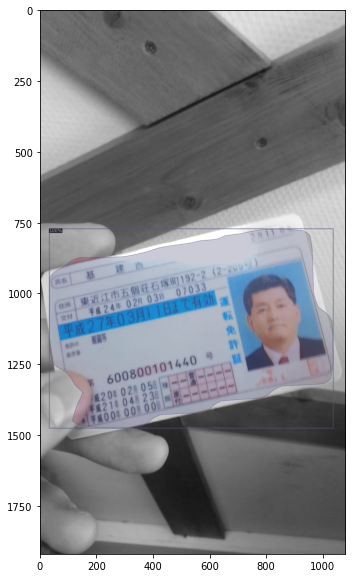

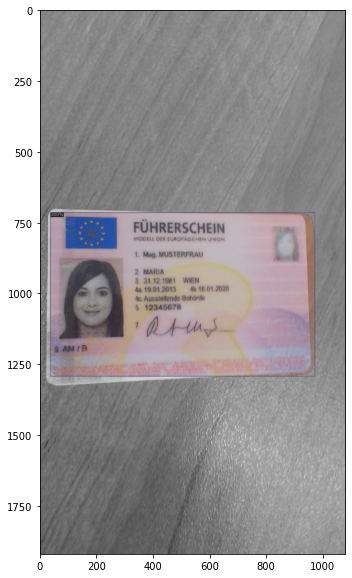

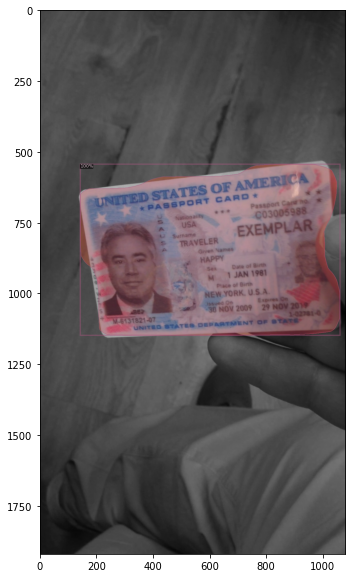

Prediction result from model: R50FPN_COCO
[07/26 11:45:19 d2.data.datasets.coco]: Loaded 4802 images in COCO format from /data/card-segmentation/midv/midv_test.json


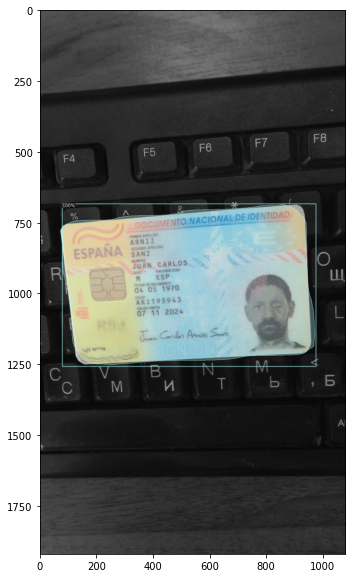

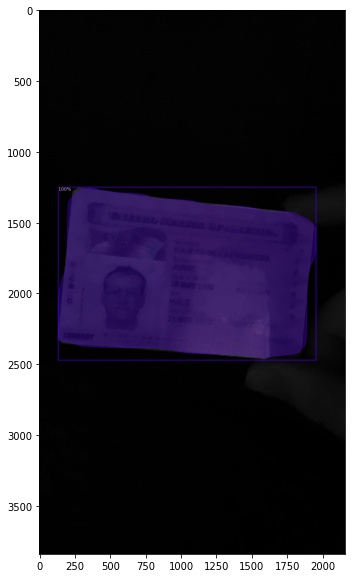

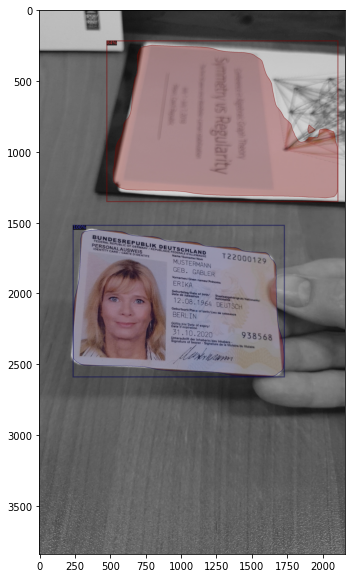

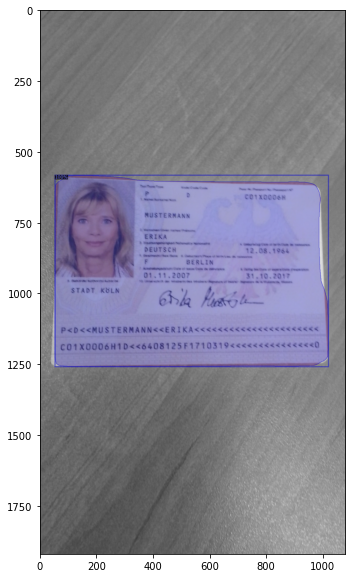

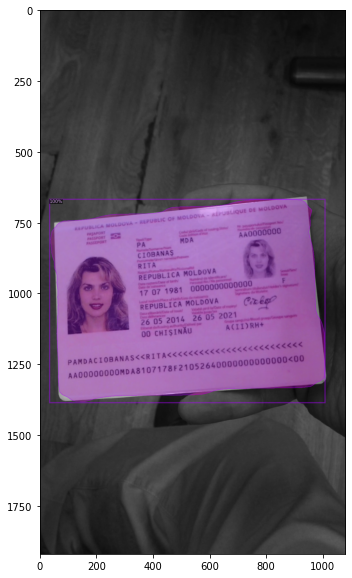

Prediction result from model: R50DV5_COCO
[07/26 11:45:28 d2.data.datasets.coco]: Loaded 4802 images in COCO format from /data/card-segmentation/midv/midv_test.json


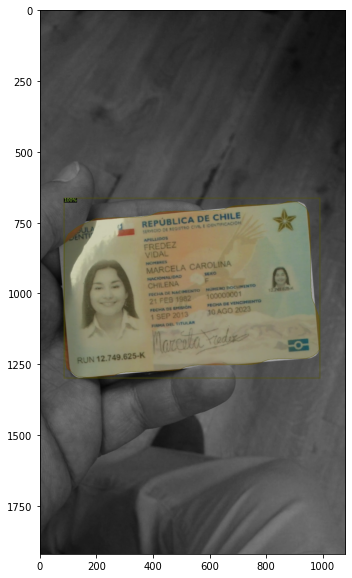

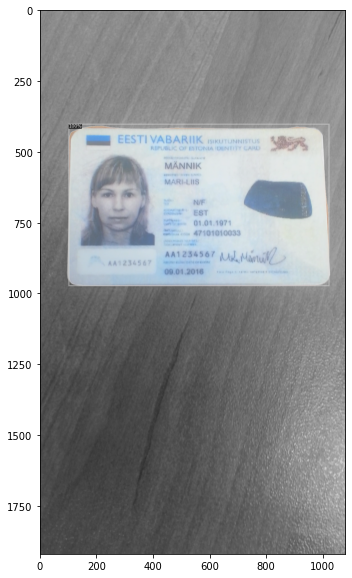

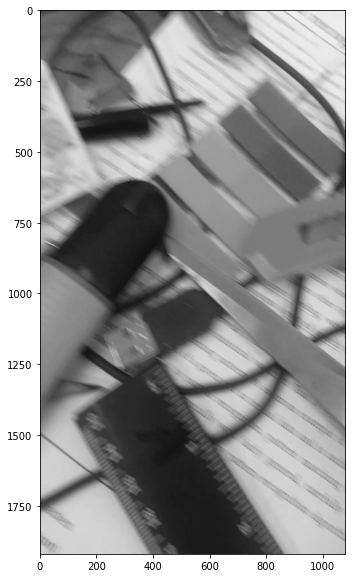

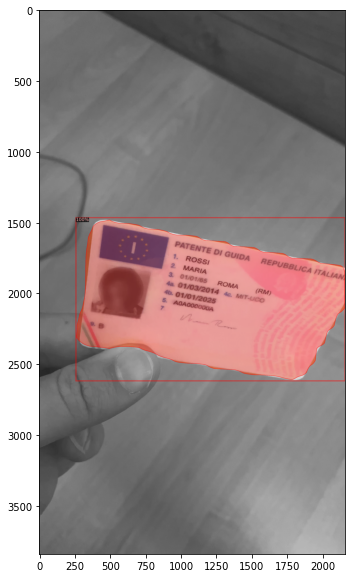

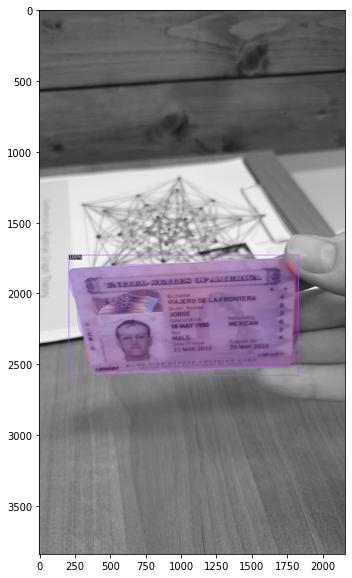

In [18]:
for model, config in models_config.items():
    print("Prediction result from model: {}".format(model))
    config.MODEL.WEIGHTS = os.path.join(config.OUTPUT_DIR, "model_final.pth")
    config.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    config.DATASETS.TEST = (f"{DATASET_NAME}_test",)
    predictor = DefaultPredictor(config)

    test_metadata = MetadataCatalog.get(f"{DATASET_NAME}_test")
    test_dataset_dicts = DatasetCatalog.get(f"{DATASET_NAME}_test")
    for d in random.sample(test_dataset_dicts, 5):
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        v = Visualizer(
            im[:, :, ::-1],
            metadata=test_metadata,
            scale=1,
            instance_mode=ColorMode.IMAGE_BW,  # remove the colors of unsegmented pixels
        )
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.figure(figsize=(14, 10))
        plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
        plt.show()